In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install catboost
!pip install optuna
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

import shap

#Preparing Data

In [18]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/NTDB-Epidural/final_data.csv', index_col = 0)

In [19]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Total ICU Length of Stay'].notna()]
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  4790
Number of patients after exclusion:  3234
Number of patients excluded with this criteria:  1556


In [20]:
#Exclude.

before = data.shape[0]
data = data[(data['Discharge Disposition'] != 'Deceased/Expired')]
data = data[(data['Discharge Disposition'] != 'Left against medical advice or discontinued care')]
after = data.shape[0]
excluded = before - after

print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  3234
Number of patients after exclusion:  3016
Number of patients excluded with this criteria:  218


In [21]:
#Define outcome of interest.

print(data['Total ICU Length of Stay'].quantile(0.80), '\n')

data.loc[data['Total ICU Length of Stay'] <= data['Total ICU Length of Stay'].quantile(0.80), 'OUTCOME'] = 0
data.loc[data['Total ICU Length of Stay'] > data['Total ICU Length of Stay'].quantile(0.80), 'OUTCOME'] = 1

data['OUTCOME'].value_counts(normalize=False, dropna=False)

4.0 



0.0    2518
1.0     498
Name: OUTCOME, dtype: int64

In [22]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [23]:
#Check data shapes.

print(y.shape)
print(x.shape)

(3016,)
(3016, 249)


In [24]:
#Split data into initial train set and test set in 80:20 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  2412
Number patients y_train dataset:  2412
Number patients x_test dataset:  604
Number patients y_test dataset:  604


In [25]:
#Split initial train set into final train set and validation set in 75:25 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  1809
Number patients train_y dataset:  1809
Number patients valid_x dataset:  603
Number patients valid_y dataset:  603


In [26]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 299
Before resampling, counts of label '0': 1510 



In [27]:
#Apply SMOTE.

from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [28]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 1510
After resampling, counts of label '0': 1510 



In [29]:
def roc_auc_ci(y_test, y_probs, positive=1):
    AUC = roc_auc_score(y_test, y_probs)
    N1 = sum(y_test == positive)
    N2 = sum(y_test != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# XGBoost

In [30]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

[I 2023-01-23 03:19:18,027] A new study created in memory with name: no-name-b202fa20-a959-4b65-aebe-cbeb34fe14db


[0]	validation-auc:0.663406
[1]	validation-auc:0.658548
[2]	validation-auc:0.660824
[3]	validation-auc:0.6762
[4]	validation-auc:0.679442
[5]	validation-auc:0.678944
[6]	validation-auc:0.673245
[7]	validation-auc:0.678141
[8]	validation-auc:0.66309
[9]	validation-auc:0.663454


[I 2023-01-23 03:19:18,768] Trial 0 finished with value: 0.6325301204819277 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6325301204819277.


[0]	validation-auc:0.513023
[1]	validation-auc:0.598537
[2]	validation-auc:0.640993
[3]	validation-auc:0.651932
[4]	validation-auc:0.653414
[5]	validation-auc:0.634787
[6]	validation-auc:0.621113
[7]	validation-auc:0.690811
[8]	validation-auc:0.661102
[9]	validation-auc:0.676879


[I 2023-01-23 03:19:19,404] Trial 1 finished with value: 0.6254733218588641 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6325301204819277.


[0]	validation-auc:0.5
[1]	validation-auc:0.585657
[2]	validation-auc:0.598537
[3]	validation-auc:0.6452
[4]	validation-auc:0.640993
[5]	validation-auc:0.677328
[6]	validation-auc:0.649704
[7]	validation-auc:0.653414
[8]	validation-auc:0.651951
[9]	validation-auc:0.634787


[I 2023-01-23 03:19:19,740] Trial 2 finished with value: 0.6254733218588641 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6325301204819277.


[0]	validation-auc:0.627137
[1]	validation-auc:0.623255
[2]	validation-auc:0.637894
[3]	validation-auc:0.642656
[4]	validation-auc:0.646749
[5]	validation-auc:0.644492
[6]	validation-auc:0.643354
[7]	validation-auc:0.643689
[8]	validation-auc:0.64585
[9]	validation-auc:0.645496


[I 2023-01-23 03:19:21,919] Trial 3 finished with value: 0.6324440619621342 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6325301204819277.


[0]	validation-auc:0.648288
[1]	validation-auc:0.648298
[2]	validation-auc:0.648365
[3]	validation-auc:0.648126
[4]	validation-auc:0.648183
[5]	validation-auc:0.648126
[6]	validation-auc:0.648049
[7]	validation-auc:0.648221
[8]	validation-auc:0.648049
[9]	validation-auc:0.648221


[I 2023-01-23 03:19:24,324] Trial 4 finished with value: 0.6294606999426277 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6325301204819277.


[0]	validation-auc:0.5
[1]	validation-auc:0.63385
[2]	validation-auc:0.63385
[3]	validation-auc:0.63385
[4]	validation-auc:0.63385


[I 2023-01-23 03:19:24,758] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.673599
[1]	validation-auc:0.699723
[2]	validation-auc:0.690993
[3]	validation-auc:0.684596
[4]	validation-auc:0.687177
[5]	validation-auc:0.688898
[6]	validation-auc:0.689195
[7]	validation-auc:0.686336
[8]	validation-auc:0.684347
[9]	validation-auc:0.685571


[I 2023-01-23 03:19:27,619] Trial 6 finished with value: 0.6570567986230637 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04528142691329445, 'alpha': 0.010014797160429703, 'max_depth': 5, 'eta': 0.08681503874329109, 'gamma': 1.7151544620195505e-06, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.6570567986230637.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.5
[4]	validation-auc:0.51027


[I 2023-01-23 03:19:28,461] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.649503
[1]	validation-auc:0.649072
[2]	validation-auc:0.648365
[3]	validation-auc:0.648221
[4]	validation-auc:0.648088


[I 2023-01-23 03:19:30,363] Trial 8 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.69235
[3]	validation-auc:0.69235
[4]	validation-auc:0.69235
[5]	validation-auc:0.69235
[6]	validation-auc:0.69235
[7]	validation-auc:0.69235
[8]	validation-auc:0.69235
[9]	validation-auc:0.69235


[I 2023-01-23 03:19:31,722] Trial 9 finished with value: 0.6237234652897303 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.009931126321758296, 'alpha': 1.5117729868865979e-05, 'max_depth': 4, 'eta': 0.00026829123048597897, 'gamma': 5.2949738366436485e-05, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.6570567986230637.


[0]	validation-auc:0.663263
[1]	validation-auc:0.675349
[2]	validation-auc:0.691528
[3]	validation-auc:0.691604
[4]	validation-auc:0.697409
[5]	validation-auc:0.711207
[6]	validation-auc:0.70829
[7]	validation-auc:0.713626
[8]	validation-auc:0.721132
[9]	validation-auc:0.719038


[I 2023-01-23 03:19:33,003] Trial 10 finished with value: 0.6234366035570854 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.6016913090485729, 'alpha': 0.003516861545788762, 'max_depth': 2, 'eta': 0.33738276515229926, 'gamma': 0.027179735912078267, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.6570567986230637.


[0]	validation-auc:0.654083
[1]	validation-auc:0.691805
[2]	validation-auc:0.683945
[3]	validation-auc:0.671792
[4]	validation-auc:0.679489
[5]	validation-auc:0.67772
[6]	validation-auc:0.669746
[7]	validation-auc:0.675521
[8]	validation-auc:0.683305
[9]	validation-auc:0.687225


[I 2023-01-23 03:19:36,836] Trial 11 finished with value: 0.6182444061962135 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.409109165337129e-05, 'alpha': 0.5044407594011535, 'max_depth': 9, 'eta': 0.38585538428714167, 'gamma': 1.2024518784549119e-08, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.6570567986230637.


[0]	validation-auc:0.689826
[1]	validation-auc:0.6989
[2]	validation-auc:0.692226
[3]	validation-auc:0.697036
[4]	validation-auc:0.692197
[5]	validation-auc:0.701377
[6]	validation-auc:0.700927
[7]	validation-auc:0.697476
[8]	validation-auc:0.698097
[9]	validation-auc:0.697935


[I 2023-01-23 03:19:40,225] Trial 12 finished with value: 0.6495410212277681 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.004128677057659532, 'alpha': 0.12116479219515162, 'max_depth': 6, 'eta': 0.04209063484881944, 'gamma': 2.429532197045886e-07, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.6570567986230637.


[0]	validation-auc:0.694521
[1]	validation-auc:0.69345
[2]	validation-auc:0.695907
[3]	validation-auc:0.696529
[4]	validation-auc:0.69804
[5]	validation-auc:0.697619
[6]	validation-auc:0.698652
[7]	validation-auc:0.695974
[8]	validation-auc:0.69999
[9]	validation-auc:0.697179


[I 2023-01-23 03:19:44,747] Trial 13 finished with value: 0.6693344807802639 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.008772378366209333, 'alpha': 0.016122305935211183, 'max_depth': 6, 'eta': 0.015071502122401456, 'gamma': 1.7215693602875058e-07, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.6693344807802639.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.69235
[3]	validation-auc:0.69235
[4]	validation-auc:0.693469
[5]	validation-auc:0.693469
[6]	validation-auc:0.687789
[7]	validation-auc:0.702333
[8]	validation-auc:0.70241
[9]	validation-auc:0.703595


[I 2023-01-23 03:19:46,683] Trial 14 finished with value: 0.6415088927137119 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.043125426724165784, 'alpha': 0.009375557559384037, 'max_depth': 4, 'eta': 0.007882988358246787, 'gamma': 8.828195648913072e-08, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.6693344807802639.


[0]	validation-auc:0.694521
[1]	validation-auc:0.693546
[2]	validation-auc:0.694712
[3]	validation-auc:0.693861
[4]	validation-auc:0.694664
[5]	validation-auc:0.694358
[6]	validation-auc:0.695802
[7]	validation-auc:0.695209
[8]	validation-auc:0.698193
[9]	validation-auc:0.698269


[I 2023-01-23 03:19:49,875] Trial 15 finished with value: 0.6307515777395296 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011900807431977616, 'alpha': 0.001851600535277945, 'max_depth': 6, 'eta': 0.007385899076343952, 'gamma': 1.2392476885231333e-08, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.6693344807802639.


[0]	validation-auc:0.692178
[1]	validation-auc:0.691949
[2]	validation-auc:0.699684
[3]	validation-auc:0.702658
[4]	validation-auc:0.7072
[5]	validation-auc:0.70918
[6]	validation-auc:0.709581
[7]	validation-auc:0.704991
[8]	validation-auc:0.702821
[9]	validation-auc:0.704006


[I 2023-01-23 03:19:51,435] Trial 16 finished with value: 0.6688181296615032 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9728978936923091, 'alpha': 0.03778326610085834, 'max_depth': 4, 'eta': 0.023508431754301035, 'gamma': 8.047959756839665e-07, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.6693344807802639.


[0]	validation-auc:0.690601
[1]	validation-auc:0.690601
[2]	validation-auc:0.690601
[3]	validation-auc:0.690601
[4]	validation-auc:0.690601


[I 2023-01-23 03:19:52,147] Trial 17 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.690849
[1]	validation-auc:0.690849
[2]	validation-auc:0.690849
[3]	validation-auc:0.690849
[4]	validation-auc:0.690849
[5]	validation-auc:0.690849
[6]	validation-auc:0.690849


[I 2023-01-23 03:19:52,813] Trial 18 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.69235
[1]	validation-auc:0.692475
[2]	validation-auc:0.699015
[3]	validation-auc:0.699235
[4]	validation-auc:0.695382
[5]	validation-auc:0.700927
[6]	validation-auc:0.703825
[7]	validation-auc:0.697762
[8]	validation-auc:0.696233
[9]	validation-auc:0.696433


[I 2023-01-23 03:19:53,135] Trial 19 finished with value: 0.6625645438898451 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.08262285983888636, 'alpha': 0.021410772655302664, 'max_depth': 4, 'eta': 0.04372349847684834, 'gamma': 5.01570437279042e-07, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.6693344807802639.


[0]	validation-auc:0.694559
[1]	validation-auc:0.690113
[2]	validation-auc:0.690132
[3]	validation-auc:0.68887
[4]	validation-auc:0.688965
[5]	validation-auc:0.689138
[6]	validation-auc:0.689711
[7]	validation-auc:0.689577
[8]	validation-auc:0.689596
[9]	validation-auc:0.689539


[I 2023-01-23 03:19:53,530] Trial 20 finished with value: 0.6332472748135399 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0006104496707604104, 'alpha': 0.001004694340843676, 'max_depth': 6, 'eta': 0.0005789133582642281, 'gamma': 5.373047379687062e-08, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.6693344807802639.


[0]	validation-auc:0.69235
[1]	validation-auc:0.692475
[2]	validation-auc:0.702563
[3]	validation-auc:0.71267
[4]	validation-auc:0.708759
[5]	validation-auc:0.700975
[6]	validation-auc:0.705183
[7]	validation-auc:0.703098
[8]	validation-auc:0.703748
[9]	validation-auc:0.703901


[I 2023-01-23 03:19:53,837] Trial 21 finished with value: 0.6690763052208835 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.08570960114739773, 'alpha': 0.02999258321611051, 'max_depth': 4, 'eta': 0.03206197658349051, 'gamma': 7.984599192826907e-07, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.6693344807802639.


[0]	validation-auc:0.663263
[1]	validation-auc:0.663263
[2]	validation-auc:0.687961
[3]	validation-auc:0.687961
[4]	validation-auc:0.693001
[5]	validation-auc:0.693001
[6]	validation-auc:0.702419
[7]	validation-auc:0.701673
[8]	validation-auc:0.69869
[9]	validation-auc:0.702132


[I 2023-01-23 03:19:54,083] Trial 22 finished with value: 0.6338496844520942 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.13852522674905857, 'alpha': 0.11788394688269499, 'max_depth': 2, 'eta': 0.010334456203713932, 'gamma': 3.5021100289367437e-06, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.6693344807802639.


[0]	validation-auc:0.69235
[1]	validation-auc:0.692475
[2]	validation-auc:0.702563
[3]	validation-auc:0.712746
[4]	validation-auc:0.709065
[5]	validation-auc:0.700803
[6]	validation-auc:0.702563
[7]	validation-auc:0.703089
[8]	validation-auc:0.698537
[9]	validation-auc:0.699015


[I 2023-01-23 03:19:54,399] Trial 23 finished with value: 0.6700803212851406 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.011840819195183852, 'alpha': 0.04381833927225852, 'max_depth': 4, 'eta': 0.0353040184218009, 'gamma': 5.161893189217231e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.684844
[1]	validation-auc:0.712689
[2]	validation-auc:0.705297
[3]	validation-auc:0.703643
[4]	validation-auc:0.705307
[5]	validation-auc:0.703261
[6]	validation-auc:0.6989
[7]	validation-auc:0.69672
[8]	validation-auc:0.696089
[9]	validation-auc:0.695735


[I 2023-01-23 03:19:54,816] Trial 24 finished with value: 0.6450372920252438 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.012975165174333675, 'alpha': 0.9764140127685723, 'max_depth': 6, 'eta': 0.1170057804942362, 'gamma': 1.5306581576643805e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.673599
[1]	validation-auc:0.688841
[2]	validation-auc:0.678208
[3]	validation-auc:0.669774
[4]	validation-auc:0.672997


[I 2023-01-23 03:19:55,054] Trial 25 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.663263
[1]	validation-auc:0.696309
[2]	validation-auc:0.692121
[3]	validation-auc:0.69934
[4]	validation-auc:0.696864
[5]	validation-auc:0.696682
[6]	validation-auc:0.68296
[7]	validation-auc:0.697849
[8]	validation-auc:0.700306
[9]	validation-auc:0.695219


[I 2023-01-23 03:19:55,290] Trial 26 finished with value: 0.6061962134251291 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.020410806261557772, 'alpha': 0.0008298798196963691, 'max_depth': 2, 'eta': 0.8969395302642215, 'gamma': 2.86548082126272e-08, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.690601
[1]	validation-auc:0.690601
[2]	validation-auc:0.690601
[3]	validation-auc:0.702352
[4]	validation-auc:0.699761
[5]	validation-auc:0.700679
[6]	validation-auc:0.689788
[7]	validation-auc:0.690534
[8]	validation-auc:0.691604
[9]	validation-auc:0.6952


[I 2023-01-23 03:19:55,557] Trial 27 finished with value: 0.6424268502581756 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.005521868846269561, 'alpha': 0.01960866747930516, 'max_depth': 3, 'eta': 0.017896593008470626, 'gamma': 4.361827374569141e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.648671
[1]	validation-auc:0.654073
[2]	validation-auc:0.656349
[3]	validation-auc:0.654217
[4]	validation-auc:0.65502


[I 2023-01-23 03:19:55,861] Trial 28 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.674421
[1]	validation-auc:0.704198
[2]	validation-auc:0.694138
[3]	validation-auc:0.684882
[4]	validation-auc:0.68733
[5]	validation-auc:0.688803
[6]	validation-auc:0.691146
[7]	validation-auc:0.688965
[8]	validation-auc:0.685485
[9]	validation-auc:0.685475


[I 2023-01-23 03:19:56,232] Trial 29 finished with value: 0.6560527825588067 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0003663243196100253, 'alpha': 0.1908161684625696, 'max_depth': 5, 'eta': 0.08110115583520845, 'gamma': 1.1474616852094423e-06, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.63385
[1]	validation-auc:0.673178
[2]	validation-auc:0.631717
[3]	validation-auc:0.65328
[4]	validation-auc:0.682148


[I 2023-01-23 03:19:56,383] Trial 30 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.701167
[3]	validation-auc:0.711484
[4]	validation-auc:0.711828
[5]	validation-auc:0.704991
[6]	validation-auc:0.704159
[7]	validation-auc:0.702429
[8]	validation-auc:0.701912
[9]	validation-auc:0.703739


[I 2023-01-23 03:19:56,697] Trial 31 finished with value: 0.6680722891566265 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.2128909692036693, 'alpha': 0.04041783099217842, 'max_depth': 4, 'eta': 0.02822395730452195, 'gamma': 9.332036329947436e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.691997
[3]	validation-auc:0.703672
[4]	validation-auc:0.707544
[5]	validation-auc:0.708434
[6]	validation-auc:0.706636
[7]	validation-auc:0.709323
[8]	validation-auc:0.701702
[9]	validation-auc:0.705508


[I 2023-01-23 03:19:56,988] Trial 32 finished with value: 0.646528973034997 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.02390471335628698, 'alpha': 0.05501061266576295, 'max_depth': 4, 'eta': 0.02137107273526004, 'gamma': 1.057077763751853e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.69235
[1]	validation-auc:0.7
[2]	validation-auc:0.695162
[3]	validation-auc:0.694865
[4]	validation-auc:0.682406
[5]	validation-auc:0.693115
[6]	validation-auc:0.704437
[7]	validation-auc:0.710815
[8]	validation-auc:0.702142
[9]	validation-auc:0.706655


[I 2023-01-23 03:19:57,326] Trial 33 finished with value: 0.6573149741824441 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.07502050931802737, 'alpha': 0.01350203145219493, 'max_depth': 4, 'eta': 0.2113243399372746, 'gamma': 6.748219122673797e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.678457
[1]	validation-auc:0.697638
[2]	validation-auc:0.692675
[3]	validation-auc:0.691002
[4]	validation-auc:0.687722
[5]	validation-auc:0.6928
[6]	validation-auc:0.693249
[7]	validation-auc:0.690208
[8]	validation-auc:0.69017
[9]	validation-auc:0.68625


[I 2023-01-23 03:19:57,691] Trial 34 finished with value: 0.6645725760183592 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.2322583808562299, 'alpha': 0.024820839000583923, 'max_depth': 5, 'eta': 0.052454048904008316, 'gamma': 3.3246525214689743e-06, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.679126
[1]	validation-auc:0.678906
[2]	validation-auc:0.680455
[3]	validation-auc:0.679633
[4]	validation-auc:0.679556
[5]	validation-auc:0.695324
[6]	validation-auc:0.695477
[7]	validation-auc:0.697351
[8]	validation-auc:0.699503
[9]	validation-auc:0.699971


[I 2023-01-23 03:19:58,045] Trial 35 finished with value: 0.6655765920826162 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.006760596146383295, 'alpha': 0.4009083781937276, 'max_depth': 5, 'eta': 0.01092110233161458, 'gamma': 2.227474290445624e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.647179
[1]	validation-auc:0.65917
[2]	validation-auc:0.659572
[3]	validation-auc:0.660566
[4]	validation-auc:0.662708


[I 2023-01-23 03:19:58,337] Trial 36 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.690601
[1]	validation-auc:0.675397
[2]	validation-auc:0.688994
[3]	validation-auc:0.677108
[4]	validation-auc:0.678619


[I 2023-01-23 03:19:58,530] Trial 37 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.694358
[1]	validation-auc:0.700344
[2]	validation-auc:0.702142
[3]	validation-auc:0.706913
[4]	validation-auc:0.70785
[5]	validation-auc:0.705871
[6]	validation-auc:0.710031
[7]	validation-auc:0.707315
[8]	validation-auc:0.707047
[9]	validation-auc:0.710623


[I 2023-01-23 03:19:58,915] Trial 38 finished with value: 0.6628227194492256 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.8718879246730737, 'alpha': 0.037025024359740345, 'max_depth': 6, 'eta': 0.024094401807294854, 'gamma': 7.906456199126135e-08, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.657468
[1]	validation-auc:0.663827
[2]	validation-auc:0.684443
[3]	validation-auc:0.694817
[4]	validation-auc:0.696567
[5]	validation-auc:0.699369
[6]	validation-auc:0.698011
[7]	validation-auc:0.697514
[8]	validation-auc:0.69585
[9]	validation-auc:0.693756


[I 2023-01-23 03:19:59,429] Trial 39 finished with value: 0.6518072289156627 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.05024404042038626, 'alpha': 0.3309189229436625, 'max_depth': 8, 'eta': 0.09510530514103814, 'gamma': 6.79065558512492e-07, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.673599
[1]	validation-auc:0.67445
[2]	validation-auc:0.674297
[3]	validation-auc:0.674374
[4]	validation-auc:0.674374


[I 2023-01-23 03:19:59,666] Trial 40 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.691997
[3]	validation-auc:0.702486
[4]	validation-auc:0.701702
[5]	validation-auc:0.708023
[6]	validation-auc:0.705097
[7]	validation-auc:0.708816
[8]	validation-auc:0.708013
[9]	validation-auc:0.7048


[I 2023-01-23 03:19:59,975] Trial 41 finished with value: 0.6690763052208835 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.2299833494130819, 'alpha': 0.052538163410076194, 'max_depth': 4, 'eta': 0.019592628676180755, 'gamma': 1.2565189290981753e-06, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.692389
[1]	validation-auc:0.692389
[2]	validation-auc:0.692389
[3]	validation-auc:0.692389
[4]	validation-auc:0.692389


[I 2023-01-23 03:20:00,211] Trial 42 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.690601
[1]	validation-auc:0.690601
[2]	validation-auc:0.690601
[3]	validation-auc:0.701951
[4]	validation-auc:0.701759
[5]	validation-auc:0.700698
[6]	validation-auc:0.699407
[7]	validation-auc:0.699484
[8]	validation-auc:0.699283
[9]	validation-auc:0.695209


[I 2023-01-23 03:20:00,504] Trial 43 finished with value: 0.6444348823866896 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0346378427701628, 'alpha': 0.025980291008098982, 'max_depth': 3, 'eta': 0.016677442996870257, 'gamma': 2.2975860962310692e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.686871
[1]	validation-auc:0.695009
[2]	validation-auc:0.691308
[3]	validation-auc:0.683725
[4]	validation-auc:0.689616


[I 2023-01-23 03:20:00,733] Trial 44 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.700727
[2]	validation-auc:0.684423
[3]	validation-auc:0.687579
[4]	validation-auc:0.708883
[5]	validation-auc:0.715978
[6]	validation-auc:0.722614
[7]	validation-auc:0.722691
[8]	validation-auc:0.729346
[9]	validation-auc:0.735303


[I 2023-01-23 03:20:01,040] Trial 45 finished with value: 0.6295180722891566 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.12240893488939102, 'alpha': 0.013515762195035894, 'max_depth': 4, 'eta': 0.35274915358407627, 'gamma': 1.4073435674780133e-06, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.702563
[3]	validation-auc:0.712211
[4]	validation-auc:0.70918
[5]	validation-auc:0.701033
[6]	validation-auc:0.705183
[7]	validation-auc:0.703175
[8]	validation-auc:0.703347
[9]	validation-auc:0.703528


[I 2023-01-23 03:20:01,369] Trial 46 finished with value: 0.6690763052208835 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.009839473226930169, 'alpha': 0.0019752288072634764, 'max_depth': 4, 'eta': 0.029495074163825713, 'gamma': 3.738841087276566e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.663263
[1]	validation-auc:0.663263
[2]	validation-auc:0.663263
[3]	validation-auc:0.687961
[4]	validation-auc:0.687961


[I 2023-01-23 03:20:01,545] Trial 47 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.690601
[1]	validation-auc:0.69127
[2]	validation-auc:0.678504
[3]	validation-auc:0.670358
[4]	validation-auc:0.684959
[5]	validation-auc:0.705336
[6]	validation-auc:0.706215
[7]	validation-auc:0.710872
[8]	validation-auc:0.719535
[9]	validation-auc:0.720109


[I 2023-01-23 03:20:01,830] Trial 48 finished with value: 0.6099541021227768 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.009994338842435474, 'alpha': 0.007508732802491288, 'max_depth': 3, 'eta': 0.3998750616772017, 'gamma': 2.312068712372826e-08, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.694521
[1]	validation-auc:0.698843
[2]	validation-auc:0.698786
[3]	validation-auc:0.699742
[4]	validation-auc:0.696558
[5]	validation-auc:0.702668
[6]	validation-auc:0.701014
[7]	validation-auc:0.699551
[8]	validation-auc:0.697581
[9]	validation-auc:0.698738


[I 2023-01-23 03:20:02,219] Trial 49 finished with value: 0.6563109581181871 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.012894987009480711, 'alpha': 0.0016965497036964619, 'max_depth': 6, 'eta': 0.04279068905206252, 'gamma': 2.511374005147728e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.69235
[1]	validation-auc:0.700344
[2]	validation-auc:0.69346
[3]	validation-auc:0.700698
[4]	validation-auc:0.703853
[5]	validation-auc:0.703155
[6]	validation-auc:0.6965
[7]	validation-auc:0.700822
[8]	validation-auc:0.704628
[9]	validation-auc:0.696892


[I 2023-01-23 03:20:02,540] Trial 50 finished with value: 0.6457831325301204 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.05296046053592949, 'alpha': 0.00017384487562151555, 'max_depth': 4, 'eta': 0.10799843711022988, 'gamma': 1.0213462271491731e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.69235
[3]	validation-auc:0.687789
[4]	validation-auc:0.708051
[5]	validation-auc:0.701167
[6]	validation-auc:0.705632
[7]	validation-auc:0.704963
[8]	validation-auc:0.709237
[9]	validation-auc:0.709715


[I 2023-01-23 03:20:02,844] Trial 51 finished with value: 0.6690763052208835 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.30103730167896675, 'alpha': 0.05235910886681302, 'max_depth': 4, 'eta': 0.014873980924668023, 'gamma': 4.5981415935764895e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.679126
[1]	validation-auc:0.678562
[2]	validation-auc:0.679097
[3]	validation-auc:0.679327
[4]	validation-auc:0.694827


[I 2023-01-23 03:20:03,079] Trial 52 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.690601
[1]	validation-auc:0.690601
[2]	validation-auc:0.701951
[3]	validation-auc:0.700201
[4]	validation-auc:0.699656
[5]	validation-auc:0.687091
[6]	validation-auc:0.68602
[7]	validation-auc:0.685676
[8]	validation-auc:0.691805
[9]	validation-auc:0.681287


[I 2023-01-23 03:20:03,357] Trial 53 finished with value: 0.6148594377510039 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.030396742556554942, 'alpha': 0.07765435538614167, 'max_depth': 3, 'eta': 0.030773665584339936, 'gamma': 1.8565495796156103e-06, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.69235
[3]	validation-auc:0.69235
[4]	validation-auc:0.69235


[I 2023-01-23 03:20:03,570] Trial 54 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.69235
[3]	validation-auc:0.69235
[4]	validation-auc:0.69235


[I 2023-01-23 03:20:03,792] Trial 55 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.673599
[1]	validation-auc:0.674641
[2]	validation-auc:0.674297
[3]	validation-auc:0.674374
[4]	validation-auc:0.693832


[I 2023-01-23 03:20:04,024] Trial 56 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.690601
[1]	validation-auc:0.704131
[2]	validation-auc:0.697992
[3]	validation-auc:0.692513
[4]	validation-auc:0.687512
[5]	validation-auc:0.690046
[6]	validation-auc:0.68515
[7]	validation-auc:0.690476
[8]	validation-auc:0.68515
[9]	validation-auc:0.688765


[I 2023-01-23 03:20:04,301] Trial 57 finished with value: 0.6411933448078027 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.43492690635128184, 'alpha': 0.008525324979073571, 'max_depth': 3, 'eta': 0.05959863907876407, 'gamma': 4.152670776174553e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.689826
[1]	validation-auc:0.688478
[2]	validation-auc:0.68996
[3]	validation-auc:0.689692
[4]	validation-auc:0.689941


[I 2023-01-23 03:20:04,597] Trial 58 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.692389
[1]	validation-auc:0.704886
[2]	validation-auc:0.696376
[3]	validation-auc:0.694617
[4]	validation-auc:0.700794
[5]	validation-auc:0.70218
[6]	validation-auc:0.704045
[7]	validation-auc:0.703222
[8]	validation-auc:0.696433
[9]	validation-auc:0.69433


[I 2023-01-23 03:20:04,897] Trial 59 finished with value: 0.6608146873207115 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04238500630305429, 'alpha': 0.626790343421423, 'max_depth': 4, 'eta': 0.1529895282647013, 'gamma': 9.927566075031798e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.6700803212851406.


[0]	validation-auc:0.690601
[1]	validation-auc:0.690601
[2]	validation-auc:0.690601
[3]	validation-auc:0.690601
[4]	validation-auc:0.690601


[I 2023-01-23 03:20:05,089] Trial 60 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.692475
[2]	validation-auc:0.701434
[3]	validation-auc:0.712096
[4]	validation-auc:0.709275
[5]	validation-auc:0.701147
[6]	validation-auc:0.70568
[7]	validation-auc:0.703079
[8]	validation-auc:0.702448
[9]	validation-auc:0.704112


[I 2023-01-23 03:20:05,419] Trial 61 finished with value: 0.6728341939185313 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.19947529475653025, 'alpha': 0.040697645587223046, 'max_depth': 4, 'eta': 0.03281843155874775, 'gamma': 1.377840212024037e-07, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.6728341939185313.


[0]	validation-auc:0.653834
[1]	validation-auc:0.669411
[2]	validation-auc:0.670482
[3]	validation-auc:0.689243
[4]	validation-auc:0.694856
[5]	validation-auc:0.700765
[6]	validation-auc:0.700708
[7]	validation-auc:0.703452
[8]	validation-auc:0.698728
[9]	validation-auc:0.698671


[I 2023-01-23 03:20:05,880] Trial 62 finished with value: 0.6618187033849685 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.1734821969591143, 'alpha': 0.033839699564512195, 'max_depth': 7, 'eta': 0.03875464052123492, 'gamma': 1.66949217106167e-07, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.6728341939185313.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.691997
[3]	validation-auc:0.702486
[4]	validation-auc:0.702065
[5]	validation-auc:0.708195
[6]	validation-auc:0.707822
[7]	validation-auc:0.709552
[8]	validation-auc:0.702936
[9]	validation-auc:0.705383


[I 2023-01-23 03:20:06,189] Trial 63 finished with value: 0.6690763052208835 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0953865034159641, 'alpha': 0.013765929389078958, 'max_depth': 4, 'eta': 0.018527523412979984, 'gamma': 3.1670648845096924e-07, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.6728341939185313.


[0]	validation-auc:0.692503
[1]	validation-auc:0.70502
[2]	validation-auc:0.695382
[3]	validation-auc:0.695056
[4]	validation-auc:0.690658
[5]	validation-auc:0.688946
[6]	validation-auc:0.693555
[7]	validation-auc:0.693144
[8]	validation-auc:0.693718
[9]	validation-auc:0.696051


[I 2023-01-23 03:20:06,519] Trial 64 finished with value: 0.6670682730923696 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.5766455584938738, 'alpha': 0.05728727190488728, 'max_depth': 4, 'eta': 0.09564895390769794, 'gamma': 6.589969987447938e-08, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.6728341939185313.


[0]	validation-auc:0.679126
[1]	validation-auc:0.678562
[2]	validation-auc:0.677644
[3]	validation-auc:0.677988
[4]	validation-auc:0.677988


[I 2023-01-23 03:20:06,772] Trial 65 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.69235
[3]	validation-auc:0.69235
[4]	validation-auc:0.69235


[I 2023-01-23 03:20:06,983] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.673599
[1]	validation-auc:0.674641
[2]	validation-auc:0.699818
[3]	validation-auc:0.690036
[4]	validation-auc:0.689845


[I 2023-01-23 03:20:07,232] Trial 67 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.690601
[1]	validation-auc:0.687885
[2]	validation-auc:0.678065
[3]	validation-auc:0.696491
[4]	validation-auc:0.706196
[5]	validation-auc:0.721687
[6]	validation-auc:0.72183
[7]	validation-auc:0.709218
[8]	validation-auc:0.706808
[9]	validation-auc:0.709524


[I 2023-01-23 03:20:07,508] Trial 68 finished with value: 0.5904188181296615 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.07537603445717961, 'alpha': 0.13743111334225067, 'max_depth': 3, 'eta': 0.5010691080804532, 'gamma': 4.6118388656061285e-07, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 0.6728341939185313.


[0]	validation-auc:0.69235
[1]	validation-auc:0.701071
[2]	validation-auc:0.703882
[3]	validation-auc:0.70284
[4]	validation-auc:0.694836
[5]	validation-auc:0.698575
[6]	validation-auc:0.695382
[7]	validation-auc:0.698174
[8]	validation-auc:0.698776
[9]	validation-auc:0.7011


[I 2023-01-23 03:20:07,840] Trial 69 finished with value: 0.673580034423408 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.1979633991119715, 'alpha': 0.053026906803437794, 'max_depth': 4, 'eta': 0.057515333229473505, 'gamma': 2.154932326296458e-07, 'grow_policy': 'lossguide'}. Best is trial 69 with value: 0.673580034423408.


[0]	validation-auc:0.690601
[1]	validation-auc:0.69345
[2]	validation-auc:0.697084
[3]	validation-auc:0.681268
[4]	validation-auc:0.682578


[I 2023-01-23 03:20:08,040] Trial 70 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.701071
[2]	validation-auc:0.707219
[3]	validation-auc:0.708338
[4]	validation-auc:0.696988
[5]	validation-auc:0.700354
[6]	validation-auc:0.701845
[7]	validation-auc:0.697829
[8]	validation-auc:0.698537
[9]	validation-auc:0.697609


[I 2023-01-23 03:20:08,337] Trial 71 finished with value: 0.6733218588640276 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.17181055924832872, 'alpha': 0.05464960690385227, 'max_depth': 4, 'eta': 0.050279885248975954, 'gamma': 2.7559204828055956e-07, 'grow_policy': 'lossguide'}. Best is trial 69 with value: 0.673580034423408.


[0]	validation-auc:0.679126
[1]	validation-auc:0.697925
[2]	validation-auc:0.691767
[3]	validation-auc:0.689233
[4]	validation-auc:0.691327


[I 2023-01-23 03:20:08,592] Trial 72 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.692475
[2]	validation-auc:0.699015
[3]	validation-auc:0.699273
[4]	validation-auc:0.695382
[5]	validation-auc:0.700908
[6]	validation-auc:0.703825
[7]	validation-auc:0.69782
[8]	validation-auc:0.696558
[9]	validation-auc:0.696548


[I 2023-01-23 03:20:08,912] Trial 73 finished with value: 0.6635685599541021 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.01648470029491798, 'alpha': 0.015985218302419408, 'max_depth': 4, 'eta': 0.04436472033030491, 'gamma': 1.0578731228951275e-06, 'grow_policy': 'lossguide'}. Best is trial 69 with value: 0.673580034423408.


[0]	validation-auc:0.692389
[1]	validation-auc:0.704714
[2]	validation-auc:0.696567
[3]	validation-auc:0.694693
[4]	validation-auc:0.698939
[5]	validation-auc:0.713492
[6]	validation-auc:0.712287
[7]	validation-auc:0.704494
[8]	validation-auc:0.697256
[9]	validation-auc:0.702457


[I 2023-01-23 03:20:09,231] Trial 74 finished with value: 0.6608146873207115 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.4996925713854265, 'alpha': 0.06688676706446527, 'max_depth': 4, 'eta': 0.1319512810646219, 'gamma': 2.9654948041323605e-07, 'grow_policy': 'lossguide'}. Best is trial 69 with value: 0.673580034423408.


[0]	validation-auc:0.673599
[1]	validation-auc:0.674565
[2]	validation-auc:0.695209
[3]	validation-auc:0.702171
[4]	validation-auc:0.69868
[5]	validation-auc:0.695468
[6]	validation-auc:0.688506
[7]	validation-auc:0.695401
[8]	validation-auc:0.692197
[9]	validation-auc:0.69367


[I 2023-01-23 03:20:09,599] Trial 75 finished with value: 0.6673264486517498 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.06561331063890345, 'alpha': 0.005273395355264957, 'max_depth': 5, 'eta': 0.02629353534585184, 'gamma': 1.961713234572447e-08, 'grow_policy': 'lossguide'}. Best is trial 69 with value: 0.673580034423408.


[0]	validation-auc:0.690601
[1]	validation-auc:0.690601
[2]	validation-auc:0.690601
[3]	validation-auc:0.690601
[4]	validation-auc:0.692427
[5]	validation-auc:0.702658
[6]	validation-auc:0.701845
[7]	validation-auc:0.701597
[8]	validation-auc:0.700841
[9]	validation-auc:0.700612


[I 2023-01-23 03:20:09,889] Trial 76 finished with value: 0.662794033275961 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.17868736999979998, 'alpha': 0.03431789374413409, 'max_depth': 3, 'eta': 0.008920800890223565, 'gamma': 4.89515201923067e-08, 'grow_policy': 'lossguide'}. Best is trial 69 with value: 0.673580034423408.


[0]	validation-auc:0.69235
[1]	validation-auc:0.702295
[2]	validation-auc:0.70459
[3]	validation-auc:0.702304
[4]	validation-auc:0.694836
[5]	validation-auc:0.699139
[6]	validation-auc:0.696864
[7]	validation-auc:0.695869
[8]	validation-auc:0.69847
[9]	validation-auc:0.695037


[I 2023-01-23 03:20:10,201] Trial 77 finished with value: 0.6770797475616752 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.10739809961949084, 'alpha': 0.017869160847943624, 'max_depth': 4, 'eta': 0.0652812041221586, 'gamma': 8.890036230348837e-08, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.691088
[1]	validation-auc:0.69475
[2]	validation-auc:0.695382
[3]	validation-auc:0.70787
[4]	validation-auc:0.707841
[5]	validation-auc:0.711675
[6]	validation-auc:0.70983
[7]	validation-auc:0.709543
[8]	validation-auc:0.706636
[9]	validation-auc:0.703366


[I 2023-01-23 03:20:10,635] Trial 78 finished with value: 0.6467871485943775 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.09907056864513292, 'alpha': 0.26609089124302443, 'max_depth': 6, 'eta': 0.07190982196648976, 'gamma': 7.685324677521296e-08, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.663263
[1]	validation-auc:0.683811
[2]	validation-auc:0.664496
[3]	validation-auc:0.679834
[4]	validation-auc:0.694138
[5]	validation-auc:0.702238
[6]	validation-auc:0.69367
[7]	validation-auc:0.692236
[8]	validation-auc:0.693048
[9]	validation-auc:0.698575


[I 2023-01-23 03:20:10,897] Trial 79 finished with value: 0.625415949512335 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.23440346145896118, 'alpha': 0.10461154655097533, 'max_depth': 2, 'eta': 0.23517328692181358, 'gamma': 4.030027596505393e-08, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.691949
[1]	validation-auc:0.709294
[2]	validation-auc:0.689463
[3]	validation-auc:0.709074
[4]	validation-auc:0.728179
[5]	validation-auc:0.721467
[6]	validation-auc:0.723427
[7]	validation-auc:0.719813
[8]	validation-auc:0.715835
[9]	validation-auc:0.702276


[I 2023-01-23 03:20:11,219] Trial 80 finished with value: 0.6057085484796327 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.6078770379170557, 'alpha': 0.8360067216776276, 'max_depth': 4, 'eta': 0.48050766720061633, 'gamma': 1.0130648656673025e-07, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.691997
[3]	validation-auc:0.703672
[4]	validation-auc:0.707506
[5]	validation-auc:0.708242
[6]	validation-auc:0.7048
[7]	validation-auc:0.707554
[8]	validation-auc:0.701473
[9]	validation-auc:0.705603


[I 2023-01-23 03:20:11,555] Trial 81 finished with value: 0.646528973034997 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.027770420734770918, 'alpha': 0.021692421405478175, 'max_depth': 4, 'eta': 0.02317749075550763, 'gamma': 2.1144216927221593e-07, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.673599
[1]	validation-auc:0.689051
[2]	validation-auc:0.677806
[3]	validation-auc:0.675971
[4]	validation-auc:0.670558


[I 2023-01-23 03:20:11,798] Trial 82 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.692475
[2]	validation-auc:0.699015
[3]	validation-auc:0.699235
[4]	validation-auc:0.695382
[5]	validation-auc:0.700908
[6]	validation-auc:0.703729
[7]	validation-auc:0.697762
[8]	validation-auc:0.696366
[9]	validation-auc:0.696625


[I 2023-01-23 03:20:12,112] Trial 83 finished with value: 0.6635685599541021 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.044673757793277986, 'alpha': 0.009807451580702151, 'max_depth': 4, 'eta': 0.042921603173363354, 'gamma': 1.32806684706208e-06, 'grow_policy': 'lossguide'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.69235
[3]	validation-auc:0.687789
[4]	validation-auc:0.70809
[5]	validation-auc:0.70174
[6]	validation-auc:0.70676
[7]	validation-auc:0.707085
[8]	validation-auc:0.706674
[9]	validation-auc:0.710375


[I 2023-01-23 03:20:12,426] Trial 84 finished with value: 0.646528973034997 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.10016753665283806, 'alpha': 0.03102677928725142, 'max_depth': 4, 'eta': 0.013017493441651366, 'gamma': 3.144881326930222e-07, 'grow_policy': 'lossguide'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.673599
[1]	validation-auc:0.699723
[2]	validation-auc:0.69083
[3]	validation-auc:0.691719
[4]	validation-auc:0.687034


[I 2023-01-23 03:20:12,676] Trial 85 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.691997
[3]	validation-auc:0.702486
[4]	validation-auc:0.707889
[5]	validation-auc:0.707219
[6]	validation-auc:0.704226
[7]	validation-auc:0.709304
[8]	validation-auc:0.701492
[9]	validation-auc:0.703748


[I 2023-01-23 03:20:13,000] Trial 86 finished with value: 0.646528973034997 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.20211328146183088, 'alpha': 0.07372935971757238, 'max_depth': 4, 'eta': 0.020607783515021037, 'gamma': 1.7545861772495883e-08, 'grow_policy': 'lossguide'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.629222
[1]	validation-auc:0.640524
[2]	validation-auc:0.66464
[3]	validation-auc:0.680799
[4]	validation-auc:0.689357


[I 2023-01-23 03:20:13,362] Trial 87 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.690601
[1]	validation-auc:0.690601
[2]	validation-auc:0.701951
[3]	validation-auc:0.699589
[4]	validation-auc:0.699618
[5]	validation-auc:0.687091
[6]	validation-auc:0.68602
[7]	validation-auc:0.686804
[8]	validation-auc:0.695181
[9]	validation-auc:0.680187


[I 2023-01-23 03:20:13,669] Trial 88 finished with value: 0.6148594377510039 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.017073222472175666, 'alpha': 0.00811446883134947, 'max_depth': 3, 'eta': 0.029353765756451784, 'gamma': 6.619730199958056e-08, 'grow_policy': 'lossguide'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.690601
[1]	validation-auc:0.690601
[2]	validation-auc:0.690601
[3]	validation-auc:0.690601
[4]	validation-auc:0.690601


[I 2023-01-23 03:20:13,869] Trial 89 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.704982
[2]	validation-auc:0.696835
[3]	validation-auc:0.695324
[4]	validation-auc:0.702907
[5]	validation-auc:0.699139
[6]	validation-auc:0.703213
[7]	validation-auc:0.697303
[8]	validation-auc:0.70327
[9]	validation-auc:0.70414


[I 2023-01-23 03:20:14,181] Trial 90 finished with value: 0.6570567986230637 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.12448176250558643, 'alpha': 0.0034200277366111176, 'max_depth': 4, 'eta': 0.12250589822841336, 'gamma': 2.4213136884177775e-06, 'grow_policy': 'lossguide'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.69235
[1]	validation-auc:0.69235
[2]	validation-auc:0.691997
[3]	validation-auc:0.702448
[4]	validation-auc:0.702582
[5]	validation-auc:0.701167
[6]	validation-auc:0.705556
[7]	validation-auc:0.704924
[8]	validation-auc:0.709046
[9]	validation-auc:0.704532


[I 2023-01-23 03:20:14,497] Trial 91 finished with value: 0.6680722891566265 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.36758250148489074, 'alpha': 0.06361099799105652, 'max_depth': 4, 'eta': 0.01527235951726709, 'gamma': 4.4089170402337293e-07, 'grow_policy': 'lossguide'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.692178
[1]	validation-auc:0.692178
[2]	validation-auc:0.692178
[3]	validation-auc:0.692178
[4]	validation-auc:0.692178


[I 2023-01-23 03:20:14,742] Trial 92 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.671505
[1]	validation-auc:0.672853
[2]	validation-auc:0.66726
[3]	validation-auc:0.665825
[4]	validation-auc:0.663119


[I 2023-01-23 03:20:15,067] Trial 93 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.674421
[1]	validation-auc:0.697409
[2]	validation-auc:0.692121
[3]	validation-auc:0.690543
[4]	validation-auc:0.687378


[I 2023-01-23 03:20:15,302] Trial 94 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69235
[1]	validation-auc:0.692475
[2]	validation-auc:0.701167
[3]	validation-auc:0.711408
[4]	validation-auc:0.70918
[5]	validation-auc:0.701998
[6]	validation-auc:0.705508
[7]	validation-auc:0.703261
[8]	validation-auc:0.703328
[9]	validation-auc:0.703614


[I 2023-01-23 03:20:15,624] Trial 95 finished with value: 0.6708261617900173 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.2707353121505671, 'alpha': 0.07115328410615805, 'max_depth': 4, 'eta': 0.0325515474445898, 'gamma': 1.0754824774651888e-07, 'grow_policy': 'lossguide'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.69235
[1]	validation-auc:0.692475
[2]	validation-auc:0.701434
[3]	validation-auc:0.711981
[4]	validation-auc:0.70874
[5]	validation-auc:0.700975
[6]	validation-auc:0.705144
[7]	validation-auc:0.702907
[8]	validation-auc:0.702515
[9]	validation-auc:0.702955


[I 2023-01-23 03:20:15,958] Trial 96 finished with value: 0.6748422260470454 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.08436891306390587, 'alpha': 0.09900925387107724, 'max_depth': 4, 'eta': 0.032584730234372465, 'gamma': 9.323984091491774e-08, 'grow_policy': 'lossguide'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.692389
[1]	validation-auc:0.705039
[2]	validation-auc:0.701769
[3]	validation-auc:0.696998
[4]	validation-auc:0.693899
[5]	validation-auc:0.692704
[6]	validation-auc:0.695659
[7]	validation-auc:0.702075
[8]	validation-auc:0.701932
[9]	validation-auc:0.697753


[I 2023-01-23 03:20:16,286] Trial 97 finished with value: 0.6718301778542742 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.061566101400456257, 'alpha': 0.4237145497685297, 'max_depth': 4, 'eta': 0.09007499608070228, 'gamma': 4.077126279843098e-08, 'grow_policy': 'lossguide'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.692389
[1]	validation-auc:0.705345
[2]	validation-auc:0.696118
[3]	validation-auc:0.693001
[4]	validation-auc:0.707038
[5]	validation-auc:0.699646
[6]	validation-auc:0.703375
[7]	validation-auc:0.703882
[8]	validation-auc:0.701492
[9]	validation-auc:0.706321


[I 2023-01-23 03:20:16,621] Trial 98 finished with value: 0.654302925989673 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.060010406130276604, 'alpha': 0.4322350307575277, 'max_depth': 4, 'eta': 0.1667374781865602, 'gamma': 3.87538577041614e-08, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.6770797475616752.


[0]	validation-auc:0.690601
[1]	validation-auc:0.675014
[2]	validation-auc:0.688918
[3]	validation-auc:0.676688
[4]	validation-auc:0.678065


[I 2023-01-23 03:20:16,854] Trial 99 pruned. Trial was pruned at iteration 5.


Number of finished trials: 100
Best trial:
  Value: 0.6770797475616752
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 0.10739809961949084
    alpha: 0.017869160847943624
    max_depth: 4
    eta: 0.0652812041221586
    gamma: 8.890036230348837e-08
    grow_policy: depthwise


In [31]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.10739809961949084, 'alpha': 0.017869160847943624, 'max_depth': 4, 'eta': 0.0652812041221586, 'gamma': 8.890036230348837e-08, 'grow_policy': 'depthwise', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


In [32]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=0.017869160847943624, eta=0.0652812041221586,
              eval_metric='auc', gamma=8.890036230348837e-08,
              grow_policy='depthwise', lambda=0.10739809961949084, max_depth=4,
              seed=31, verbosity=0)

In [33]:
#Make predictions on the test set based on the trained XGBoost model.

preds_xgb = xgb.predict(x_test)

probs_xgb = xgb.predict_proba(x_test)
probs_xgb = probs_xgb[:, 1]

In [34]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)
xgb_f1 = round(f1_score(preds_xgb,y_test), 3)
xgb_acc = round(accuracy_score(preds_xgb,y_test), 3)
xgb_mcc = round(matthews_corrcoef(y_test, preds_xgb), 3)
xgb_auroc = round(roc_auc_score(y_test, probs_xgb), 3)
xgb_auroc_ci_low, xgb_auroc_ci_high = roc_auc_ci(y_test, probs_xgb)
xgb_auroc_ci_low = round(xgb_auroc_ci_low, 3)
xgb_auroc_ci_high = round(xgb_auroc_ci_high, 3)
xgb_auroc = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_low) + ' - ' + str(xgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (xgb_precision))
print("Recall: %.3f" % (xgb_recall))
print("F1 Score: %.3f" %(xgb_f1))
print('Accuracy: %.3f' % (xgb_acc))
print('MCC: %.3f' % (xgb_mcc))
print('AUROC (95% CI): ', (xgb_auroc))

Precision: 0.287
Recall: 0.491
F1 Score: 0.362
Accuracy: 0.843
MCC: 0.293
AUROC (95% CI):  0.745 (0.685 - 0.805)


In [35]:
#Evaluate XGBoost model (PRC and AUPRC).

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)
xgb_auprc = round(auc(xgb_recall, xgb_precision), 3)

print('AUPRC: %.3f' % (xgb_auprc))

AUPRC: 0.417


In [36]:
#Recalculate precision and recall for calculation purposes.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)

xgb_results = [xgb_precision, xgb_recall, xgb_f1, xgb_acc, xgb_mcc, xgb_auroc, xgb_auprc]

In [37]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)

# LightGBM

In [38]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

[I 2023-01-23 03:20:19,515] A new study created in memory with name: no-name-c98df93c-904c-4c8b-b41e-5fb3b32e35ea
[I 2023-01-23 03:20:19,924] Trial 0 finished with value: 0.5954388984509466 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.5954388984509466.
[I 2023-01-23 03:20:20,406] Trial 1 finished with value: 0.6167527251864601 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fraction': 0.45363982991084084, 'bagging_fraction': 0.629435960515788, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 1 with value: 0.6167527251864601.
[I 2023-01-23 03:20:20,994] Trial 2 finished with value: 0.6034710269650029 an

Number of finished trials: 100
Best trial:
  Value: 0.6545897877223178
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 9.909366042763622
    lambda_l2: 0.004628070613986678
    num_leaves: 44
    feature_fraction: 0.8063760068336584
    bagging_fraction: 0.8947434401479799
    bagging_freq: 7
    min_child_samples: 72


In [39]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 9.909366042763622, 'lambda_l2': 0.004628070613986678, 'num_leaves': 44, 'feature_fraction': 0.8063760068336584, 'bagging_fraction': 0.8947434401479799, 'bagging_freq': 7, 'min_child_samples': 72, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


In [40]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

LGBMClassifier(bagging_fraction=0.8947434401479799, bagging_freq=7,
               feature_fraction=0.8063760068336584, lambda_l1=9.909366042763622,
               lambda_l2=0.004628070613986678, metric='binary_logloss',
               min_child_samples=72, num_leaves=44, objective='binary',
               random_state=31, verbosity=-1)

In [41]:
#Make predictions on the test set based on the trained model.

preds_lgb = lgb.predict(x_test)

probs_lgb = lgb.predict_proba(x_test)
probs_lgb = probs_lgb[:, 1]

In [42]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)
lgb_f1 = round(f1_score(preds_lgb,y_test), 3)
lgb_acc = round(accuracy_score(preds_lgb,y_test), 3)
lgb_mcc = round(matthews_corrcoef(y_test, preds_lgb), 3)
lgb_auroc = round(roc_auc_score(y_test, probs_lgb), 3)
lgb_auroc_ci_low, lgb_auroc_ci_high = roc_auc_ci(y_test, probs_lgb)
lgb_auroc_ci_low = round(lgb_auroc_ci_low, 3)
lgb_auroc_ci_high = round(lgb_auroc_ci_high, 3)
lgb_auroc = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_low) + ' - ' + str(lgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (lgb_precision))
print("Recall: %.3f" % (lgb_recall))
print("F1 Score: %.3f" %(lgb_f1))
print('Accuracy: %.3f' % (lgb_acc))
print('MCC: %.3f' % (lgb_mcc))
print('AUROC (95% CI): ', (lgb_auroc))

Precision: 0.309
Recall: 0.483
F1 Score: 0.377
Accuracy: 0.841
MCC: 0.300
AUROC (95% CI):  0.735 (0.674 - 0.796)


In [43]:
#Evaluate LightGBM model (PRC and AUPRC).

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)
lgb_auprc = round(auc(lgb_recall, lgb_precision), 3)

print('AUPRC: %.3f' % (lgb_auprc))

AUPRC: 0.394


In [44]:
#Recalculate precision and recall for calculation purposes.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)

lgb_results = [lgb_precision, lgb_recall, lgb_f1, lgb_acc, lgb_mcc, lgb_auroc, lgb_auprc]

In [45]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)

# CatBoost

In [46]:
#Hyperparameter tuning for CatBoost.

from optuna.integration import CatBoostPruningCallback

def objective(trial: optuna.Trial) -> float:

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "random_state": 31,
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc

if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    cb_params = {}
    
    for key, value in trial.params.items():
        cb_params[key] = value

[I 2023-01-23 03:21:08,641] A new study created in memory with name: no-name-e40da7b6-fbe1-4879-9d7b-cc47e66bf7d3
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 03:24:24,465] Trial 0 finished with value: 0.6447504302925989 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.058926810135424286, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.435346894873128}. Best is trial 0 with value: 0.6447504302925989.
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 03:24:25,386] Trial 1 finished with value: 0.6332185886402754 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.046618730161301844, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.43630899917515}. Best is trial 0 with value: 0.6447504302925989.
CatBoostPruningCallback is

Number of finished trials: 36
Best trial:
  Value: 0.6545611015490533
  Params: 
    objective: Logloss
    colsample_bylevel: 0.07283167610206305
    depth: 11
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 1.3344771766885848


In [47]:
#See CatBoost hyperparameters.

cb_params['used_ram_limit'] = '3gb'
cb_params['eval_metric'] = 'AUC'
cb_params['random_state'] = 31

print(cb_params)

{'objective': 'Logloss', 'colsample_bylevel': 0.07283167610206305, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3344771766885848, 'used_ram_limit': '3gb', 'eval_metric': 'AUC', 'random_state': 31}


In [48]:
#Fit CatBoost.

from catboost import CatBoostClassifier

cb = CatBoostClassifier(**cb_params)

cb.fit(train_x, train_y)

Learning rate set to 0.016516
0:	total: 141ms	remaining: 2m 20s
1:	total: 817ms	remaining: 6m 47s
2:	total: 1.48s	remaining: 8m 12s
3:	total: 2.1s	remaining: 8m 43s
4:	total: 2.69s	remaining: 8m 55s
5:	total: 3.44s	remaining: 9m 29s
6:	total: 4.09s	remaining: 9m 40s
7:	total: 4.78s	remaining: 9m 53s
8:	total: 5.42s	remaining: 9m 56s
9:	total: 6.11s	remaining: 10m 5s
10:	total: 6.72s	remaining: 10m 4s
11:	total: 7.39s	remaining: 10m 8s
12:	total: 8.03s	remaining: 10m 9s
13:	total: 8.75s	remaining: 10m 16s
14:	total: 9.32s	remaining: 10m 11s
15:	total: 10.1s	remaining: 10m 20s
16:	total: 10.8s	remaining: 10m 22s
17:	total: 11.4s	remaining: 10m 22s
18:	total: 12.2s	remaining: 10m 30s
19:	total: 13s	remaining: 10m 36s
20:	total: 13.7s	remaining: 10m 36s
21:	total: 14.3s	remaining: 10m 36s
22:	total: 15s	remaining: 10m 35s
23:	total: 15.6s	remaining: 10m 33s
24:	total: 16.3s	remaining: 10m 33s
25:	total: 16.3s	remaining: 10m 11s
26:	total: 17s	remaining: 10m 14s
27:	total: 17.1s	remaining: 

In [49]:
#Make predictions on the test set based on the trained model.

preds_cb = cb.predict(x_test)

probs_cb = cb.predict_proba(x_test)
probs_cb = probs_cb[:, 1]

In [50]:
#Evaluate CatBoost model.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)
cb_f1 = round(f1_score(preds_cb,y_test), 3)
cb_acc = round(accuracy_score(preds_cb,y_test), 3)
cb_mcc = round(matthews_corrcoef(y_test, preds_cb), 3)
cb_auroc = round(roc_auc_score(y_test, probs_cb), 3)
cb_auroc_ci_low, cb_auroc_ci_high = roc_auc_ci(y_test, probs_cb)
cb_auroc_ci_low = round(cb_auroc_ci_low, 3)
cb_auroc_ci_high = round(cb_auroc_ci_high, 3)
cb_auroc = str(cb_auroc) + ' (' + str(cb_auroc_ci_low) + ' - ' + str(cb_auroc_ci_high) + ')'

print("Precision: %.3f" % (cb_precision))
print("Recall: %.3f" % (cb_recall))
print("F1 Score: %.3f" %(cb_f1))
print('Accuracy: %.3f' % (cb_acc))
print('MCC: %.3f' % (cb_mcc))
print('AUROC (95% CI): ', (cb_auroc))

Precision: 0.213
Recall: 0.556
F1 Score: 0.308
Accuracy: 0.851
MCC: 0.278
AUROC (95% CI):  0.733 (0.672 - 0.794)


In [51]:
#Evaluate CatBoost model (PRC and AUPRC).

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)
cb_auprc = round(auc(cb_recall, cb_precision), 3)

print('AUPRC: %.3f' % (cb_auprc))

AUPRC: 0.389


In [52]:
#Recalculate precision and recall for calculation purposes.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)

cb_results = [cb_precision, cb_recall, cb_f1, cb_acc, cb_mcc, cb_auroc, cb_auprc]

In [53]:
#Recalculate precision recall curve for plotting purposes.

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)

# Random Forest

In [54]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

[I 2023-01-23 03:41:59,800] A new study created in memory with name: no-name-8f8edadb-d48b-4659-80d5-63549bc92e98
[I 2023-01-23 03:42:01,037] Trial 0 finished with value: 0.6335341365461847 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.6335341365461847.
[I 2023-01-23 03:42:02,167] Trial 1 finished with value: 0.6407917383820999 and parameters: {'criterion': 'entropy', 'max_features': 'auto', 'max_depth': 45, 'n_estimators': 200, 'min_samples_leaf': 2, 'min_samples_split': 10}. Best is trial 1 with value: 0.6407917383820999.
[I 2023-01-23 03:42:13,334] Trial 2 finished with value: 0.6059667240390132 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 35, 'n_estimators': 2000, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 1 with value: 0.6407917383820999.
[I 2023-01-23 03:42:14,508] Trial 3 finished with value: 0.611

Number of finished trials: 24
Best trial:
  Value: 0.6588066551921974
  Params: 
    criterion: entropy
    max_features: None
    max_depth: 4
    n_estimators: 700
    min_samples_leaf: 3
    min_samples_split: 3


In [55]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'n_estimators': 700, 'min_samples_leaf': 3, 'min_samples_split': 3, 'random_state': 31}


In [56]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=None,
                       min_samples_leaf=3, min_samples_split=3,
                       n_estimators=700, random_state=31)

In [57]:
#Make predictions on the test set based on the trained model.

preds_rf = rf.predict(x_test)

probs_rf = rf.predict_proba(x_test)
probs_rf = probs_rf[:, 1]

In [58]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)
rf_f1 = round(f1_score(preds_rf,y_test), 3)
rf_acc = round(accuracy_score(preds_rf,y_test), 3)
rf_mcc = round(matthews_corrcoef(y_test, preds_rf), 3)
rf_auroc = round(roc_auc_score(y_test, probs_rf), 3)
rf_auroc_ci_low, rf_auroc_ci_high = roc_auc_ci(y_test, probs_rf)
rf_auroc_ci_low = round(rf_auroc_ci_low, 3)
rf_auroc_ci_high = round(rf_auroc_ci_high, 3)
rf_auroc = str(rf_auroc) + ' (' + str(rf_auroc_ci_low) + ' - ' + str(rf_auroc_ci_high) + ')'

print("Precision: %.3f" % (rf_precision))
print("Recall: %.3f" % (rf_recall))
print("F1 Score: %.3f" %(rf_f1))
print('Accuracy: %.3f' % (rf_acc))
print('MCC: %.3f' % (rf_mcc))
print('AUROC (95% CI): ', (rf_auroc))

Precision: 0.415
Recall: 0.379
F1 Score: 0.396
Accuracy: 0.803
MCC: 0.279
AUROC (95% CI):  0.735 (0.675 - 0.796)


In [59]:
#Evaluate Random Forest model (PRC and AUPRC).

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)
rf_auprc = round(auc(rf_recall, rf_precision), 3)

print('AUPRC: %.3f' % (rf_auprc))

AUPRC: 0.358


In [60]:
#Recalculate precision and recall for calculation purposes.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)

rf_results = [rf_precision, rf_recall, rf_f1, rf_acc, rf_mcc, rf_auroc, rf_auprc]

In [61]:
#Recalculate precision recall curve for plotting purposes.

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)

# ROC and PR Curves

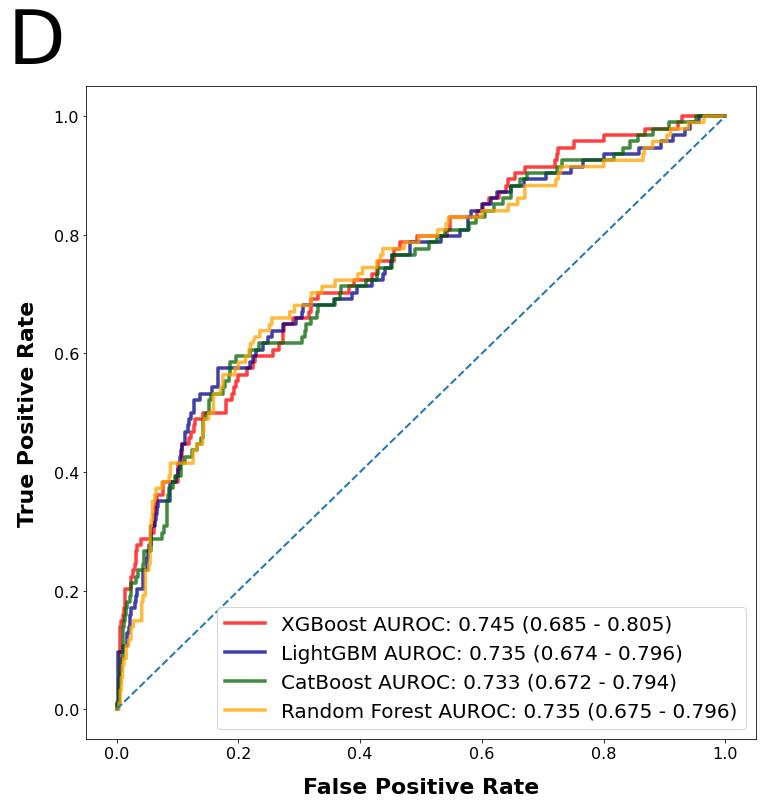

In [62]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'red', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='darkblue', linewidth = 3.5, alpha = 0.75)

cb_fpr, cb_tpr, _ = roc_curve(y_test, probs_cb)
cb_label = 'CatBoost AUROC: ' + cb_auroc
pyplot.plot(cb_fpr, cb_tpr, label = cb_label, color = 'darkgreen', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'orange', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('D', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/icu-los_roc.png', dpi=300)
pyplot.show()

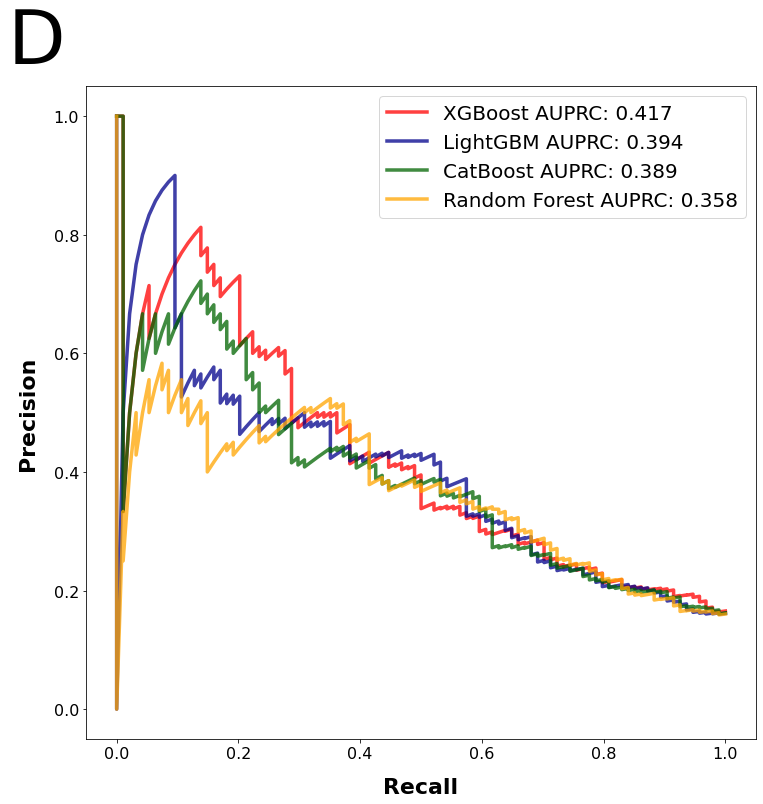

In [63]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

pyplot.plot(xgb_recall, xgb_precision, label='XGBoost AUPRC: {:.3f}'.format(xgb_auprc), color = 'red', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall, lgb_precision, label='LightGBM AUPRC: {:.3f}'.format(lgb_auprc), color = 'darkblue', linewidth = 3.5, alpha = 0.75)
pyplot.plot(cb_recall, cb_precision, label='CatBoost AUPRC: {:.3f}'.format(cb_auprc), color = 'darkgreen', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall, rf_precision, label='Random Forest AUPRC: {:.3f}'.format(rf_auprc), color = 'orange', linewidth = 3.5, alpha = 0.75)


pyplot.title('D', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/icu-los_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [64]:
results = {'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results}

results = pd.DataFrame(results, columns = ['XGBoost', 'LightGBM', 'CatBoost', 'Random Forest'])

results

,XGBoost,LightGBM,CatBoost,Random Forest
0,0.287,0.309,0.213,0.415
1,0.491,0.483,0.556,0.379
2,0.362,0.377,0.308,0.396
3,0.843,0.841,0.851,0.803
4,0.293,0.3,0.278,0.279
5,0.745 (0.685 - 0.805),0.735 (0.674 - 0.796),0.733 (0.672 - 0.794),0.735 (0.675 - 0.796)
6,0.417,0.394,0.389,0.358


In [65]:
results = pd.DataFrame({'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results})

results = results.T

results.columns = ['Precision', 'Recall', 'F1', 'Accuracy', 'MCC', 'AUROC (95% CI)', 'AUPRC']

results.to_csv('/content/drive/MyDrive/NTDB-Epidural/icu-los_results.csv')

results

,Precision,Recall,F1,Accuracy,MCC,AUROC (95% CI),AUPRC
XGBoost,0.287,0.491,0.362,0.843,0.293,0.745 (0.685 - 0.805),0.417
LightGBM,0.309,0.483,0.377,0.841,0.3,0.735 (0.674 - 0.796),0.394
CatBoost,0.213,0.556,0.308,0.851,0.278,0.733 (0.672 - 0.794),0.389
Random Forest,0.415,0.379,0.396,0.803,0.279,0.735 (0.675 - 0.796),0.358


# SHAP Plots

In [66]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [67]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test)
xgb_shap_values = xgb_explainer(x_test)

Permutation explainer: 605it [01:45,  5.36it/s]


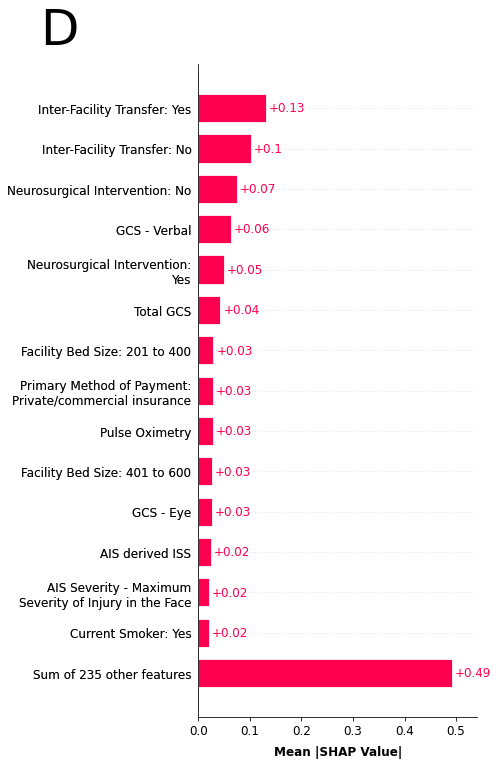

In [68]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('D', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/icu-los_shap_xgb.png', dpi=300, bbox_inches='tight')

In [69]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test)
lgb_shap_values = lgb_explainer(x_test)

Permutation explainer: 605it [02:04,  4.45it/s]


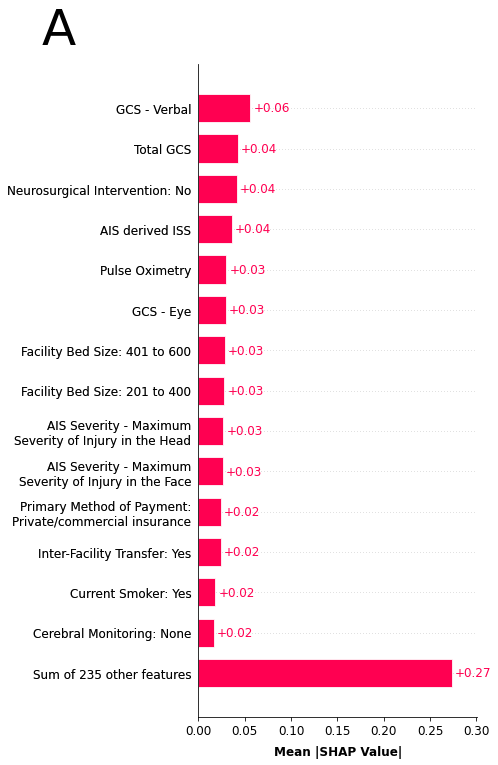

In [70]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/icu-los_shap_lgb.png', dpi=300, bbox_inches='tight')

In [71]:
#Calculate SHAP values for CatBoost.

cb_explainer = shap.Explainer(cb.predict, x_test)
cb_shap_values = cb_explainer(x_test)

Permutation explainer: 605it [02:13,  4.17it/s]


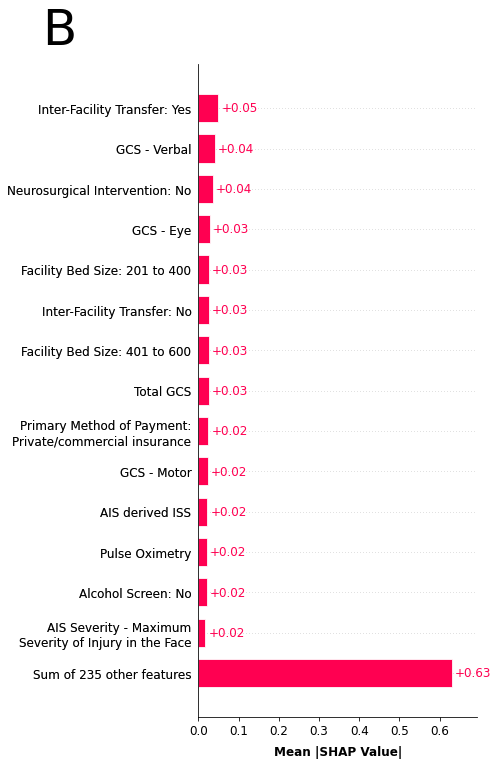

In [72]:
#Plot SHAP bar plot for CatBoost.

shap.plots.bar(cb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/icu-los_shap_cb.png', dpi=300, bbox_inches='tight')

In [73]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test)
rf_shap_values = rf_explainer(x_test)

Permutation explainer: 605it [09:48,  1.01it/s]


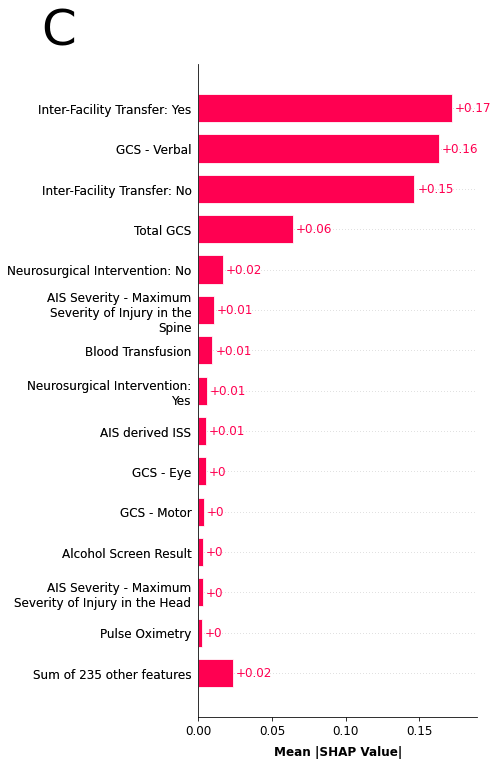

In [74]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/icu-los_shap_rf.png', dpi=300, bbox_inches='tight')